In [21]:
# Importing Modules and libraries needed for AWS S3 storage, Deep Learning and Image Processing 
import os
import boto3
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import PIL
import tensorflow as tf
import splitfolders
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50, MobileNet
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D

## Data Collection

In [2]:
# Constants
img_height = 224
img_width = 224
batch_size = 1
AWS_ACCESS_KEY_ID = 
AWS_SECRET_ACCESS_KEY = 
REGION_NAME = "us-east-2"
bucket_name = "capstone-pill-images"
data_prefix = "data/data"
local_drug_directory = "local_drug_directory"
train_dir = "output/train/"
valid_dir = "output/val/"

In [3]:
# Create an S3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=REGION_NAME
)

In [23]:
# Function to download images from S3 bucket to a local directory with subdirectories
def download_images_from_s3(bucket_name, prefix, local_directory):
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    for obj in response.get('Contents', []):
        key = obj['Key']
        local_path = os.path.join(local_directory, os.path.relpath(key, prefix))
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        s3.download_file(bucket_name, key, local_path)

In [ ]:
# to convert images to arrays

# subdirectories = [d for d in os.listdir(local_drug_directory) if os.path.isdir(os.path.join(local_drug_directory, d))]

# # Collect all image files from all subdirectories
# all_image_files = []
# for subdirectory in subdirectories:
#     subdirectory_path = os.path.join(local_drug_directory, subdirectory)

#     # List all image files in the subdirectory
#     image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg'))]

#     # Add the image files to the combined list
#     all_image_files.extend(os.path.join(subdirectory_path, f) for f in image_files)
    
# random.shuffle(all_image_files)

# number_of_img = 5


# for i in range(number_of_img):
    
#     random_image_file = all_image_files.pop()
    
#     image = mpimg.imread(random_image_file)
    
#     np.expand_dims(image, axis=0)
    
#     image = image/225

## Display Sample Images

In [5]:
# Download training images
download_images_from_s3(bucket_name, data_prefix , local_drug_directory)

def show_sample_images(local_directory):
    subdirectories = [d for d in os.listdir(local_directory) if os.path.isdir(os.path.join(local_directory, d))]
    if not subdirectories:
        print("No subdirectories found in the directory.")
        return

    all_image_files = []
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(local_directory, subdirectory)
        image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg'))]
        all_image_files.extend(os.path.join(subdirectory_path, f) for f in image_files)

    random.shuffle(all_image_files)
    num_images_to_display = 5

    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i in range(num_images_to_display):
        if not all_image_files:
            break
        random_image_file = all_image_files.pop()
        img = mpimg.imread(random_image_file)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

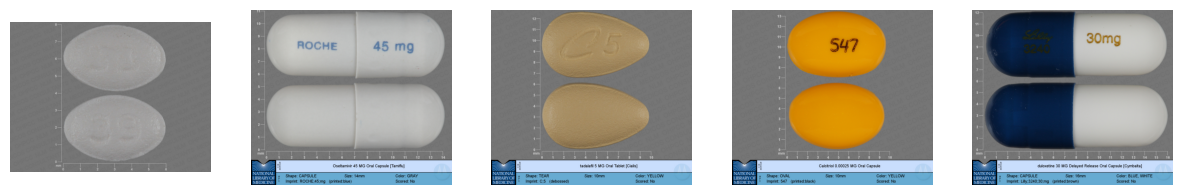

In [19]:
# Display examples
show_sample_images(local_drug_directory)

## Preprocess the Image Data

In [7]:
# Split the downloaded image folder into train, validation, and test folders
splitfolders.ratio(local_drug_directory, output="output", seed=1337, ratio=(.8, 0.1, 0.1))


Copying files: 552 files [00:02, 185.63 files/s]


In [8]:
# Rescale the images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Using ImageDataGenerator and flow_from_directory to preprocess the images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical"
)

Found 437 images belonging to 23 classes.


In [10]:
# Using ImageDataGenerator and flow_from_directory to preprocess the images
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical"
)


Found 46 images belonging to 23 classes.


In [18]:
# To extract the class names for labels
class_names = train_generator.class_indices.keys()

# Model Optimization

In [12]:
# Function to load then model with non-trainable params
def base_model_optimizer(model_name):
    base_model_optimizer = model_name(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model_optimizer.trainable = False
    return base_model_optimizer

In [13]:
# Create different variable names for base models
VGG16 = base_model_optimizer(VGG16)
RestNet50 = base_model_optimizer(ResNet50)
MobileNet = base_model_optimizer(MobileNet)

In [14]:
# Add the base models to a list
base_models = []
base_models.append(('VGG16',VGG16))
base_models.append(('RestNet50',RestNet50))
base_models.append(('MobileNet',MobileNet))

In [15]:
# Empty lists for storing model name, model loss, and model accuracy
names = []
accuracy = []
loss = []

In [16]:
# Loop through base model to load the base model into our Sequential model
for name, base_model in base_models:
    model = Sequential()

    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(23, activation="softmax"))
    model.summary()
    
    # Compile the model
    model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
    
    # Fit the model to training data
    model.fit(train_generator, epochs=2)
    
    # Evaluate with validation data
    model_loss, model_accuracy = model.evaluate(validation_generator, verbose=2)
    
    # Append the empty lists with respective values
    loss.append(model_loss)
    accuracy.append(model_accuracy)
    names.append(name)

# Create a dataframe
df_models = pd.DataFrame({'Name': names, 
                   'Accuracy' : accuracy, 
                   'Loss' : loss})

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 23)                11799     
                                                                 
Total params: 14726487 (56.18 MB)
Trainable params: 11799 (46.09 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/2
437/437 [==============================] - 149s 336ms/step - loss: 2.7969 - accuracy: 0.2197
Epoch 2/2
437/437 [==============================] - 149s 340ms/step - loss: 1.9668 - accuracy: 0.5904
46/

In [17]:
# Display the dataframe
df_models

,Name,Accuracy,Loss
0,VGG16,0.739130,1.629041
1,RestNet50,0.043478,3.212537
2,MobileNet,1.000000,0.025928
